# Семинар 12. Временные ряды. 

Основано на материалах Елены Кантонистовой.

## Чтение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (5, 7)

# данные по продажам в Индии в различных городах и штатах
df = pd.read_csv('MarketArrivals_Ind.csv')

# Прогнозирование временного ряда

In [2]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012


In [3]:
df.date = pd.DatetimeIndex(df.date)

# Отсортируем и добавим date в индекс
df = df.sort_values(by = "date")
df.index = pd.PeriodIndex(df.date, freq='M')

In [4]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
1996-01,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON,1996-01-01
1996-02,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON,1996-02-01
1996-03,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON,1996-03-01
1996-04,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON,1996-04-01
1996-05,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON,1996-05-01


Будем работать с данными в городе Бангалор

In [5]:
dfBang = df.loc[df.city == "BANGALORE"].copy()

In [6]:
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01
2004-02,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01
2004-03,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01
2004-04,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01
2004-05,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01


In [7]:
# Удалим лишние столбцы
dfBang = dfBang.drop(["market", "month", "year", "state", "city", "priceMin", "priceMax"], axis = 1)

In [8]:
dfBang.shape

(146, 3)

In [9]:
dfBang.head()

,quantity,priceMod,date
date,,,
2004-01,227832,991,2004-01-01
2004-02,225133,793,2004-02-01
2004-03,221952,556,2004-03-01
2004-04,185150,465,2004-04-01
2004-05,137390,455,2004-05-01


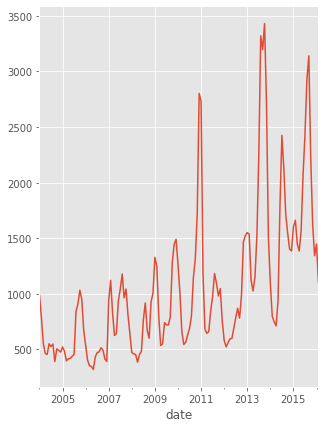

In [10]:
dfBang.priceMod.plot();

## Начнем с трех простых моделей прогноза цены

### 1. Прогнозирование средним (Mean Constant Model)
### 2. Линейная модель (Linear Trend Model)
### 3. Линейная модель с регрессии (Linear Regression Model)

### Логарифмическое преобразование данных
Логарифмирование помогает стабилизировать разброс значений.

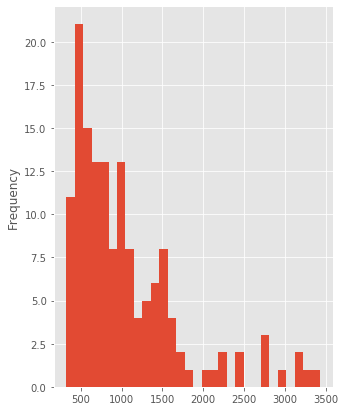

In [11]:
dfBang.priceMod.plot(kind = "hist", bins = 30)

При визуализации можем заметить, что есть данные, далеко отстающие от среднего значения, что может искажать модель регрессии. Наша задача минимизировать влияние таких данных. Желательно не исключая их.  
В этом случае самый распространенный вариант действия - логарифмирование переменной.

In [12]:
dfBang['priceModLog'] = np.log(dfBang.priceMod + 1)
dfBang.head()

,quantity,priceMod,date,priceModLog
date,,,,
2004-01,227832,991,2004-01-01,6.90
2004-02,225133,793,2004-02-01,6.68
2004-03,221952,556,2004-03-01,6.32
2004-04,185150,465,2004-04-01,6.14
2004-05,137390,455,2004-05-01,6.12


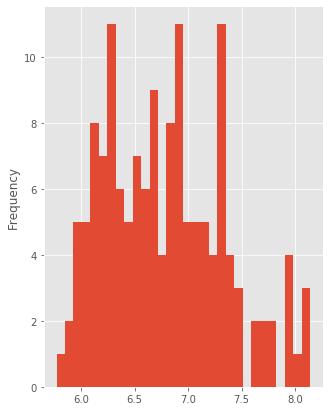

In [13]:
dfBang.priceModLog.plot(kind = "hist", bins = 30)

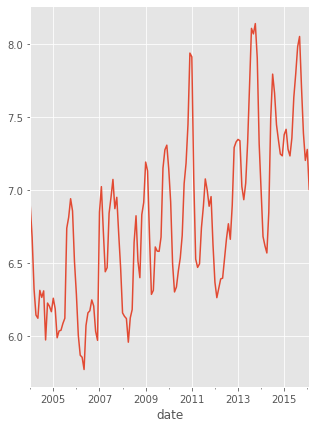

In [14]:
dfBang.priceModLog.plot()

## 1.1. Прогнозирование средним 

In [15]:
model_mean_pred = dfBang.priceModLog.mean()

In [16]:
# Запишем это значение в priceMean
dfBang["priceMean"] = np.exp(model_mean_pred)

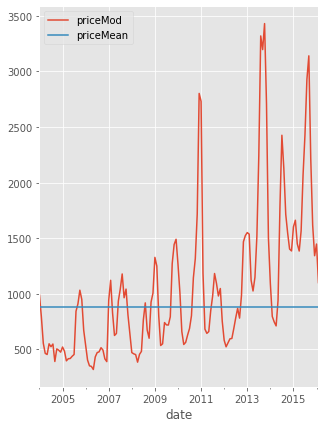

In [17]:
dfBang.plot(kind="line", x="date", y = ["priceMod", "priceMean"])

**Как мерить качество?**

Чтобы обучать регрессионные модели, нужно определиться, как именно измеряется качество предсказаний.   
Будем использовать метрику RMSE (Root Mean Squared Error) - корень среднего квадрата отклонения.

$$RMSE = \Sigma \sqrt{ (\hat{y} - y)^2/n} $$ , 
где $\hat{y}$ это предсказанное значение y

#### Какие еще метрики применимы в задачах с временными рядами?

In [18]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [19]:
model_mean_RMSE = RMSE(dfBang.priceMean, dfBang.priceMod)
model_mean_RMSE

683.6865690495794

In [20]:
dfBangResults = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])
dfBangResults.head()

,Model,Forecast,RMSE


In [21]:
dfBangResults.loc[0,"Model"] = "Mean"
dfBangResults.loc[0,"Forecast"] = np.exp(model_mean_pred)
dfBangResults.loc[0,"RMSE"] = model_mean_RMSE
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,885.72,683.69


## 1.2. Линейная модель

Построим линейную зависимость между priceModLog and time.   
Уравнение регрессии строится с помощью метода наимменьших квадратов.

In [22]:
dfBang.head()

,quantity,priceMod,date,priceModLog,priceMean
date,,,,,
2004-01,227832,991,2004-01-01,6.90,885.72
2004-02,225133,793,2004-02-01,6.68,885.72
2004-03,221952,556,2004-03-01,6.32,885.72
2004-04,185150,465,2004-04-01,6.14,885.72
2004-05,137390,455,2004-05-01,6.12,885.72


In [23]:
dfBang.dtypes

quantity                int64
priceMod                int64
date           datetime64[ns]
priceModLog           float64
priceMean             float64
dtype: object

In [24]:
dfBang.date.min()

Timestamp('2004-01-01 00:00:00')

In [25]:
dfBang["timeIndex"] = dfBang.date - dfBang.date.min()

In [26]:
dfBang.timeIndex

date
2004-01      0 days
2004-02     31 days
2004-03     60 days
2004-04     91 days
2004-05    121 days
             ...   
2015-10   4291 days
2015-11   4322 days
2015-12   4352 days
2016-01   4383 days
2016-02   4414 days
Freq: M, Name: timeIndex, Length: 146, dtype: timedelta64[ns]

In [27]:
dfBang["timeIndex"] =  dfBang["timeIndex"]/np.timedelta64(1, 'M')

In [28]:
dfBang.timeIndex

date
2004-01     0.00
2004-02     1.02
2004-03     1.97
2004-04     2.99
2004-05     3.98
           ...  
2015-10   140.98
2015-11   142.00
2015-12   142.98
2016-01   144.00
2016-02   145.02
Freq: M, Name: timeIndex, Length: 146, dtype: float64

In [29]:
dfBang["timeIndex"] = dfBang["timeIndex"].round(0).astype(int)

In [30]:
dfBang.timeIndex.tail()

date
2015-10    141
2015-11    142
2015-12    143
2016-01    144
2016-02    145
Freq: M, Name: timeIndex, dtype: int64

In [31]:
dfBang.head()

,quantity,priceMod,date,priceModLog,priceMean,timeIndex
date,,,,,,
2004-01,227832,991,2004-01-01,6.90,885.72,0
2004-02,225133,793,2004-02-01,6.68,885.72,1
2004-03,221952,556,2004-03-01,6.32,885.72,2
2004-04,185150,465,2004-04-01,6.14,885.72,3
2004-05,137390,455,2004-05-01,6.12,885.72,4


In [32]:
model_linear = smf.ols('priceModLog ~ timeIndex', data = dfBang).fit()

In [33]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     139.8
Date:                Sat, 15 May 2021   Prob (F-statistic):           5.79e-23
Time:                        14:55:45   Log-Likelihood:                -72.159
No. Observations:                 146   AIC:                             148.3
Df Residuals:                     144   BIC:                             154.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1142      0.066     92.963      0.000       5.984       6.244
timeIndex      0.0093      0.001     11.822      0.000       0.008       0.011
==============================================================================
Omnibus:                        4.755   Durbin-Watson:                   0.384
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                4.747
Skew:                           0.405   Prob(JB):                       0.0931
Kurtosis:                       2.649   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Выведем параметры нашей линейной модели

In [34]:
model_linear.params

Intercept   6.11
timeIndex   0.01
dtype: float64

$$ price = 0.01 \cdot time + 6.11 $$

In [35]:
c = model_linear.params[0]
c

6.1141906123556184

In [36]:
m = model_linear.params[1]
m

0.00927182619111075

In [37]:
model_linear_pred = model_linear.predict()

In [38]:
model_linear_pred

array([6.11419061, 6.12346244, 6.13273426, 6.14200609, 6.15127792,
       6.16054974, 6.16982157, 6.1790934 , 6.18836522, 6.19763705,
       6.20690887, 6.2161807 , 6.22545253, 6.23472435, 6.24399618,
       6.25326801, 6.26253983, 6.27181166, 6.28108348, 6.29035531,
       6.29962714, 6.30889896, 6.31817079, 6.32744261, 6.33671444,
       6.34598627, 6.35525809, 6.36452992, 6.37380175, 6.38307357,
       6.3923454 , 6.40161722, 6.41088905, 6.42016088, 6.4294327 ,
       6.43870453, 6.44797636, 6.45724818, 6.46652001, 6.47579183,
       6.48506366, 6.49433549, 6.50360731, 6.51287914, 6.52215096,
       6.53142279, 6.54069462, 6.54996644, 6.55923827, 6.5685101 ,
       6.57778192, 6.58705375, 6.59632557, 6.6055974 , 6.61486923,
       6.62414105, 6.63341288, 6.64268471, 6.65195653, 6.66122836,
       6.67050018, 6.67977201, 6.68904384, 6.69831566, 6.70758749,
       6.71685931, 6.72613114, 6.73540297, 6.74467479, 6.75394662,
       6.76321845, 6.77249027, 6.7817621 , 6.79103392, 6.80030

In [39]:
dfBang["priceLinear"] = np.exp(model_linear_pred)

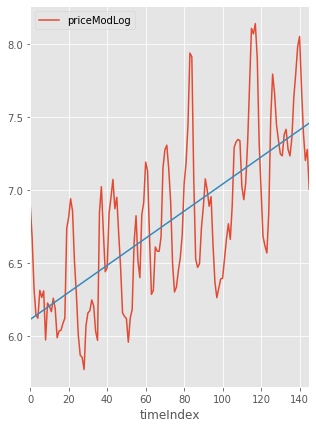

In [40]:
dfBang.plot(kind="line", x="timeIndex", y = "priceModLog")
plt.plot(dfBang.timeIndex,model_linear_pred, '-')

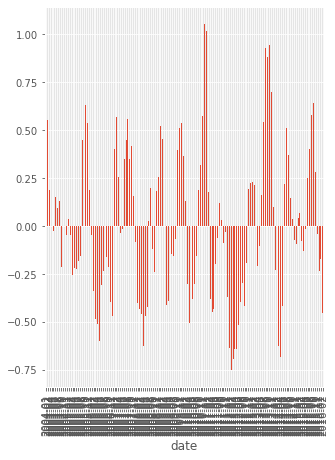

In [41]:
model_linear.resid.plot(kind = "bar")

Посчитаем ошибку RMSE на линейной модели:

In [42]:
model_linear_RMSE = RMSE(dfBang.priceLinear, dfBang.priceMod)
model_linear_RMSE

518.3417573562166

In [43]:
dfBangResults.loc[1,"Model"] = "Linear"
dfBangResults.loc[1,"Forecast"] = 'Linear'
dfBangResults.loc[1,"RMSE"] = model_linear_RMSE
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,885.72,683.69
1,Linear,Linear,518.34


## 1.3 Линейная модель с регрессией

In [44]:
## Построим регрессию, используя несколько переменных timeIndex и np.log(quantity)
model_linear_quantity = smf.ols('priceModLog ~ timeIndex + np.log(quantity)', data = dfBang).fit()

In [45]:
model_linear_quantity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     74.15
Date:                Sat, 15 May 2021   Prob (F-statistic):           8.04e-23
Time:                        14:55:46   Log-Likelihood:                -69.733
No. Observations:                 146   AIC:                             145.5
Df Residuals:                     143   BIC:                             154.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.1853      0.880      4.756      0.000       2.446       5.925
timeIndex            0.0084      0.001      9.773      0.000       0.007       0.010
np.log(quantity)     0.1527      0.069      2.198      0.030       0.015       0.290
==============================================================================
Omnibus:                        5.101   Durbin-Watson:                   0.412
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                4.960
Skew:                           0.403   Prob(JB):                       0.0837
Kurtosis:                       2.594   Cond. No.                     2.29e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
dfBang.head()

,quantity,priceMod,date,priceModLog,priceMean,timeIndex,priceLinear
date,,,,,,,
2004-01,227832,991,2004-01-01,6.90,885.72,0,452.23
2004-02,225133,793,2004-02-01,6.68,885.72,1,456.44
2004-03,221952,556,2004-03-01,6.32,885.72,2,460.69
2004-04,185150,465,2004-04-01,6.14,885.72,3,464.99
2004-05,137390,455,2004-05-01,6.12,885.72,4,469.32


In [47]:
dfBang["priceLinearQuantity"] = np.exp(model_linear_quantity.predict())

In [48]:
model_linear_q_pred = model_linear_quantity.predict()

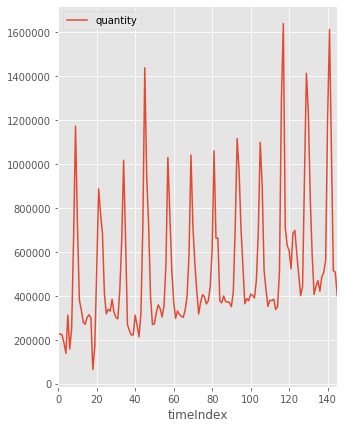

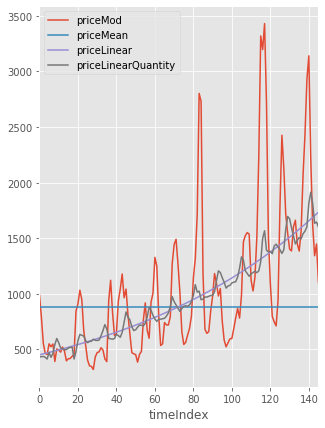

In [49]:
dfBang.plot(kind = "line", x="timeIndex", y = "quantity")
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", 
                                             "priceLinear", "priceLinearQuantity"])

In [50]:
dfBangResults.loc[2,"Model"] = "Mean"
dfBangResults.loc[2,"Forecast"] = "trend+regression"
dfBangResults.loc[2,"RMSE"] = RMSE(dfBang.priceMod, dfBang.priceLinearQuantity)
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,885.72,683.69
1,Linear,Linear,518.34
2,Mean,trend+regression,505.07


## 2 Выделение тренда и сезонности



**Аддитивная модель** 
$${Y_t} = t (trend) + s (seasonality) + r (residual)$$

![](https://miro.medium.com/max/1360/0*JWWglnH4RBR-SbxC.png)

**Мультипликативная модель** 
$${Y_t} = t (trend) * s (seasonality) * r (residual)$$

Как видим, отличие мультипликативной модели от аддитивной состоит в том, 
что в мультипликативной модели сезонная и случайная составляющие определены в виде относительных величин (коэффициентов), 
а в аддитивной модели – в виде абсолютных величин.   
Эти модели в практических расчетах дадут близкие результаты, если амплитуда колебаний уровней ряда слабо изменяется во времени

### Расчет лагов
Представим временной ряд в виде последовательности разницы между значениями.  
Рассчитаем лаги, выведем их на графике

In [51]:
# Рассчитаем лаги
dfBang["priceModLogShift1"] = dfBang.priceModLog.shift()

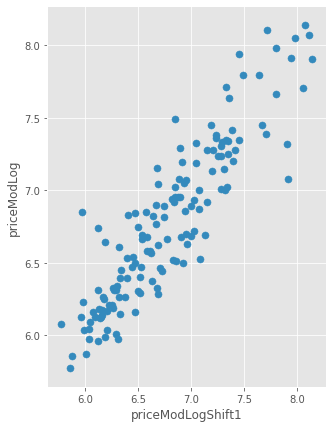

In [52]:
# Выведем на графике priceModLog и priceModLogShift1
dfBang.plot(kind= "scatter", y = "priceModLog", x = "priceModLogShift1", s = 50)

In [53]:
dfBang["priceModLogDiff"] = dfBang.priceModLog - dfBang.priceModLogShift1
# dfBang["priceModLogDiff"].diff()
# np.diff(dfBang["priceModLogDiff"])

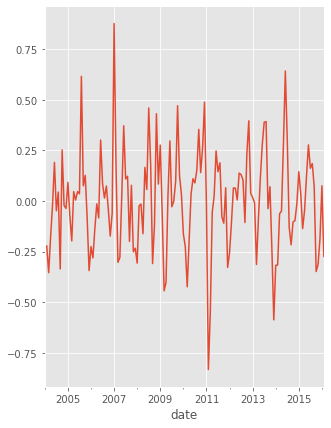

In [54]:
dfBang.priceModLogDiff.plot()

### Декомпозиция 
Декомпозируем наш временной ряд на тренд и сезонность

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [56]:
dfBang.index = dfBang.index.to_timestamp()

In [57]:
#timestamp, datetime

In [58]:
dfBang.head()

,quantity,priceMod,date,priceModLog,priceMean,timeIndex,priceLinear,priceLinearQuantity,priceModLogShift1,priceModLogDiff
date,,,,,,,,,,
2004-01-01,227832,991,2004-01-01,6.90,885.72,0,452.23,432.33,nan,nan
2004-02-01,225133,793,2004-02-01,6.68,885.72,1,456.44,435.20,6.90,-0.22
2004-03-01,221952,556,2004-03-01,6.32,885.72,2,460.69,437.93,6.68,-0.35
2004-04-01,185150,465,2004-04-01,6.14,885.72,3,464.99,429.58,6.32,-0.18
2004-05-01,137390,455,2004-05-01,6.12,885.72,4,469.32,413.92,6.14,-0.02


In [59]:
decomposition = seasonal_decompose(dfBang.priceModLog, model = "additive")

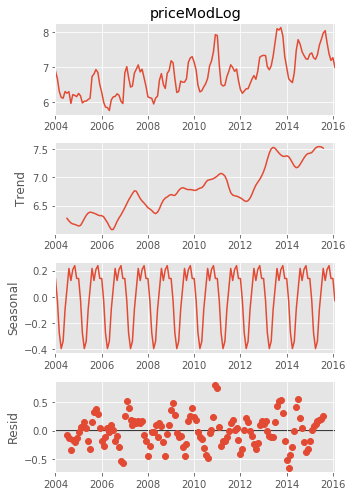

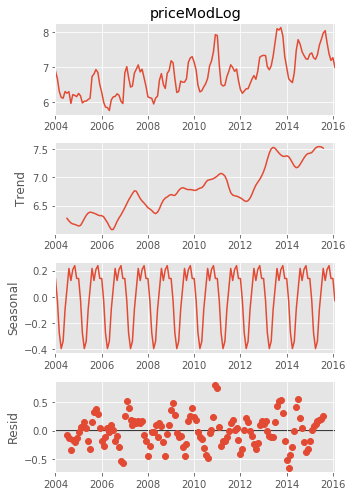

In [60]:
decomposition.plot()

In [61]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [62]:
# Построим ряд по тренду и сезонности
dfBang["priceDecomp"] = np.exp(trend + seasonal)

In [63]:
# Расчет RMSE
model_Decomp_RMSE = RMSE(dfBang.priceDecomp, dfBang.priceMod)
model_Decomp_RMSE

373.9670905950972

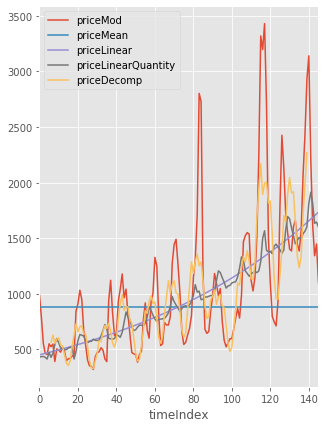

In [64]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", "priceLinearQuantity", "priceDecomp"])

In [65]:
dfBangResults

,Model,Forecast,RMSE
0,Mean,885.72,683.69
1,Linear,Linear,518.34
2,Mean,trend+regression,505.07


In [66]:
dfBangResults.loc[3,"Model"] = "priceDecomp"
dfBangResults.loc[3,"Forecast"] = 'priceDecomp'
dfBangResults.loc[3,"RMSE"] = model_Decomp_RMSE
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,885.72,683.69
1,Linear,Linear,518.34
2,Mean,trend+regression,505.07
3,priceDecomp,priceDecomp,373.97


## 3 Стационарность ряда


In [67]:
test = sm.tsa.adfuller(dfBang.priceMod)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

adf:  -4.004401077671534
p-value:  0.00138764044231547
Critical values:  {'1%': -3.4769274060112707, '5%': -2.8819726324025625, '10%': -2.577665408088415}
Единичных корней нет, ряд стационарен


## 4 Построение модели АRIMA


In [68]:
ts = dfBang.priceModLog
ts_diff = dfBang.priceModLogDiff
ts_diff.dropna(inplace = True)

In [69]:
# ACF и PACF 
from statsmodels.tsa.stattools import acf, pacf

In [70]:
lag_acf = acf(ts_diff, nlags=20)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


In [71]:
lag_acf

array([ 1.        ,  0.40230417, -0.02854545, -0.21475526, -0.23768709,
       -0.26343919, -0.22043119, -0.0858012 , -0.07535489,  0.01505532,
        0.12365055,  0.20872999,  0.15813609,  0.02052324, -0.01291853,
       -0.07093661, -0.17999336, -0.09524554, -0.04882742, -0.08852867,
       -0.188139  ])

In [72]:
ACF = pd.Series(lag_acf)

In [73]:
ACF

0     1.00
1     0.40
2    -0.03
3    -0.21
4    -0.24
5    -0.26
6    -0.22
7    -0.09
8    -0.08
9     0.02
10    0.12
11    0.21
12    0.16
13    0.02
14   -0.01
15   -0.07
16   -0.18
17   -0.10
18   -0.05
19   -0.09
20   -0.19
dtype: float64

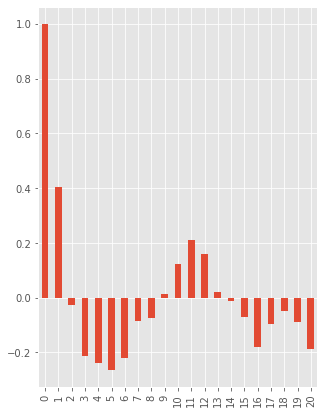

In [74]:
ACF.plot(kind = "bar")

In [75]:
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

In [76]:
PACF = pd.Series(lag_pacf)

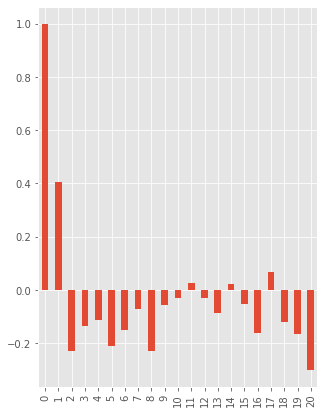

In [77]:
PACF.plot(kind = "bar")

## Построим модель ARIMA 

In [78]:
from statsmodels.tsa.arima_model import ARIMA

In [79]:
ts_diff.head()

date
2004-02-01   -0.22
2004-03-01   -0.35
2004-04-01   -0.18
2004-05-01   -0.02
2004-06-01    0.19
Freq: MS, Name: priceModLogDiff, dtype: float64

In [80]:
# ARIMA Model (1,0,1)
model_AR1MA = ARIMA(ts_diff, order=(1,0,1))

In [81]:
results_ARIMA = model_AR1MA.fit(disp = -1)

In [82]:
results_ARIMA.fittedvalues.head()

date
2004-02-01   -0.00
2004-03-01   -0.09
2004-04-01   -0.14
2004-05-01   -0.04
2004-06-01    0.00
Freq: MS, dtype: float64

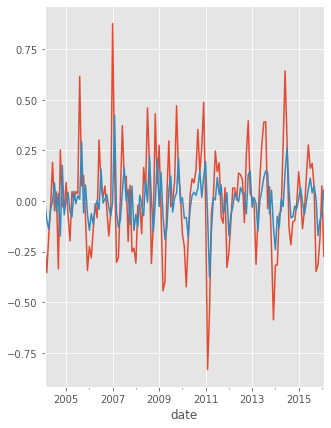

In [83]:
ts_diff.plot()
results_ARIMA.fittedvalues.plot()

In [84]:
ts_diff.sum()

0.10515888242798699

In [85]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.tail()

date
2015-10-01    0.01
2015-11-01   -0.17
2015-12-01   -0.10
2016-01-01   -0.06
2016-02-01    0.05
Freq: MS, dtype: float64

In [86]:
predictions_ARIMA_diff.sum()

0.0719967966834966

In [87]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.tail()

date
2015-10-01   0.34
2015-11-01   0.17
2015-12-01   0.08
2016-01-01   0.02
2016-02-01   0.07
Freq: MS, dtype: float64

In [88]:
ts.index[0]

Timestamp('2004-01-01 00:00:00', freq='MS')

In [89]:
predictions_ARIMA_log = pd.Series(ts, index=ts.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.tail()

date
2015-10-01   8.05
2015-11-01   7.56
2015-12-01   7.28
2016-01-01   7.30
2016-02-01   7.08
Freq: MS, dtype: float64

In [90]:
dfBang['priceARIMA'] = np.exp(predictions_ARIMA_log)

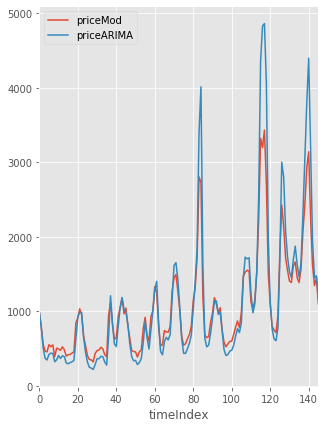

In [91]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceARIMA"])

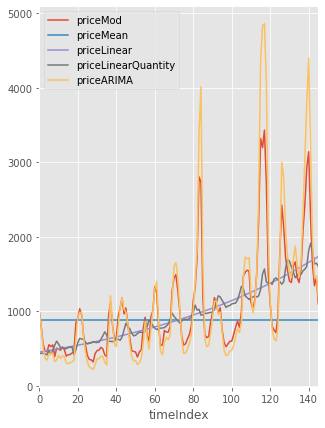

In [92]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", 
                                             "priceLinearQuantity", "priceARIMA"])

In [93]:
# RMSE
model_arima_RMSE = RMSE(dfBang.priceARIMA, dfBang.priceMod)
model_arima_RMSE

332.7305191664211

In [94]:
dfBangResults.loc[4,"Model"] = "ARIMA"
dfBangResults.loc[4,"Forecast"] = 'ARIMA'
dfBangResults.loc[4,"RMSE"] = model_arima_RMSE
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,885.72,683.69
1,Linear,Linear,518.34
2,Mean,trend+regression,505.07
3,priceDecomp,priceDecomp,373.97
4,ARIMA,ARIMA,332.73
